# Converting EtOAc Data

In Yates & McClellane, 1967 there are reported values for rate vs [H2SO4] in extreme acid mixtures for hydrolysis of esters. The author include EtOAc data in their plots but do not repport the values in Table 1 of that paper.

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

We are pointed to work by Bell and also by Jaques

"The Kinetics of Ester Hydrolysis in Concentrated Aqueous Acids." R.P. Bell, A.L. Dowding, J.A. Noble, *J. Chem. Soc.* **1955**, 3106–3110. https://doi.org/10.1039/JR9550003106.

"The Hydrolysis of Ethyl Acetate in Concentrated Aqueous Sulphuric Acid." D. Jaques, *J. Chem. Soc.* **1965**, 3854–3904. https://doi.org/10.1039/JR9650003854.

Both report rates in sulphuric acid solution.  The data from Jaques is %H2SO4 but the data from Bell is in molar. Fortunately the H0 values are reported and we have built interpolator functions that use data sets of H0 vs %H2SO4 that can convert H0 to %H2SO4.

We can also attempt a more cumbersome conversion by converting the molarity to %H2SO4 using molar mass and tables of density vs conc. Will both of these methods agree?



## Setup

the code below will setup libraries and variables

In [5]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2SO4byPercentWtinH0()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


## Comparing Data

Below we will plot the data for rate vs %H2SO4 for the data from table 1 of the paper



In [9]:
###################################################
### Import the data and perform calculations
###################################################

Data_File_Name = "Bell1955.csv"
Filename = github_location + Data_File_Name

df_Bell = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

print("Data from Bell 1955\n")

interpolator_H0 = interpolators.MakeInterpolationFunctionForH2SO4byPercentWtinH0()
Percent = interpolator_H0(df_Bell["H0"])
df_Bell["%H2SO4"] = Percent
display(df_Bell)

Data from Bell 1955



,[H2SO4] mole/L,10^5 kobs,H0,%H2SO4
0,1.35,18.8,-0.31,10.845793
1,1.37,19.8,-0.33,11.132173
2,1.87,30.9,-0.62,15.284209
3,2.85,56.1,-1.15,22.830763
4,3.08,65.5,-1.25,24.239641
5,3.63,79.7,-1.50,27.725747
6,4.25,104.0,-1.80,31.819505
7,4.76,128.0,-2.05,35.136614
8,6.75,192.0,-3.03,47.050545


In [10]:

print("Data from Bell 1955\n")

interpolator_H0 = interpolators.MakeInterpolationFunctionMolarToH2SO4byPercentWt()
Percent = interpolator_H0(df_Bell["[H2SO4] mole/L"])
df_Bell["%H2SO4byMolar"] = Percent
display(df_Bell)

Data from Bell 1955



,[H2SO4] mole/L,10^5 kobs,H0,%H2SO4,%H2SO4byMolar
0,1.35,18.8,-0.31,10.845793,11.992702
1,1.37,19.8,-0.33,11.132173,12.157030
2,1.87,30.9,-0.62,15.284209,16.202243
3,2.85,56.1,-1.15,22.830763,23.714755
4,3.08,65.5,-1.25,24.239641,25.390681
5,3.63,79.7,-1.50,27.725747,29.263192
6,4.25,104.0,-1.80,31.819505,33.408467
7,4.76,128.0,-2.05,35.136614,36.654794
8,6.75,192.0,-3.03,47.050545,48.110851


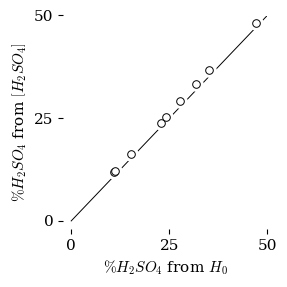

,[H2SO4] mole/L,10^5 kobs,H0,%H2SO4,%H2SO4byMolar,Difference
0,1.35,18.8,-0.31,10.845793,11.992702,1.146909
1,1.37,19.8,-0.33,11.132173,12.157030,1.024856
2,1.87,30.9,-0.62,15.284209,16.202243,0.918034
3,2.85,56.1,-1.15,22.830763,23.714755,0.883992
4,3.08,65.5,-1.25,24.239641,25.390681,1.151040
5,3.63,79.7,-1.50,27.725747,29.263192,1.537445
6,4.25,104.0,-1.80,31.819505,33.408467,1.588962
7,4.76,128.0,-2.05,35.136614,36.654794,1.518180
8,6.75,192.0,-3.03,47.050545,48.110851,1.060306


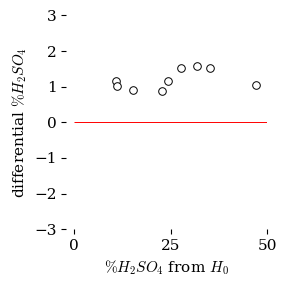

Mean differential is 1.203 +/- 0.258
Standard error of the mean is 0.091
95% confidence interval of the mean is 0.211


In [38]:
x = df_Bell["%H2SO4"]
y = df_Bell["%H2SO4byMolar"]

###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from $H_0$" 
y_label = r"$\%H_2SO_4$ from $\left[H_2SO_4\right]$" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-2,50]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
ax.set(xticks = [0,25,50],
       yticks = [0,25,50]
        )
# 1:1 line
x1 = np.linspace(0, 50, 100)
y1 = x1
ax.plot(x1, y1, 
        color = "black", linewidth=0.7, linestyle="-", 
        zorder = 0)     
plt.savefig("plots/plot3.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################

diff = y - x
df_Bell["Difference"] = diff
display(df_Bell)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from $H_0$" 
y_label = r"differential $\%H_2SO_4$" 


###################################################
### Differential Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-3,3]
        )
# Data points for kobs vs Acidity

ax.scatter(x, diff, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, diff,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
        )
ax.hlines(0, xmin=0, xmax=50, colors="red", linestyles="solid", linewidth=0.7)
plt.savefig("plots/plot4.pdf")
plt.show()

mean = np.mean(diff)
print(f"Mean differential is {mean:0.3f} +/- {np.std(diff):0.3f}")

# stderr from standard deviation of the mean
stdev = stats.sem(diff)
print(f"Standard error of the mean is {stdev:0.3f}")
# 95% confidence interval of the mean
conf95 = stdev * stats.t.ppf((1 + 0.95) / 2., len(diff)-1)
print(f"95% confidence interval of the mean is {conf95:0.3f}")
#conf95range = stats.t.interval(0.95, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))-mean




In [ ]:
dY_no_min = dY[dY != dY.min()].reset_index(drop=True)
print(dY_no_min)

In [ ]:
df_table1a_sorted = df_table1a.sort_values(by="10^2kobs", ascending=True)
display(df_table1a_sorted)

In [4]:
df_table1a = df_table1.iloc[:-3]
display(df_table1a)

,Ester,%H2SO4,10^2kobs
0,MeOAc,14.1,1.50
1,MeOAc,20.7,2.61
2,MeOAc,28.3,4.22
3,MeOAc,34.8,6.41
4,MeOAc,40.4,8.14
5,MeOAc,45.4,10.40
6,MeOAc,50.2,11.40
7,MeOAc,55.2,13.30
8,MeOAc,60.4,13.80
9,MeOAc,65.2,11.90


## Bibliography

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

In [5]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
#df1 = (df1.loc[0:11])   ### Select only the given lines

##############################################################
### Perform calculations
##############################################################

df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
#df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter

df1["Molar_H2O"] = molesH2O
X_H2O = 1-df1["X_H2SO4"]          # mole fraction H2O in H2SO4
gamma_H2O = df1["aH2O"]/(X_H2O)   # activity coefficient for H2O in H2SO4
df1["Molar_aH2O"] = gamma_H2O * df1["Molar_H2O"]

display(df1)

KeyError: 'kobs'

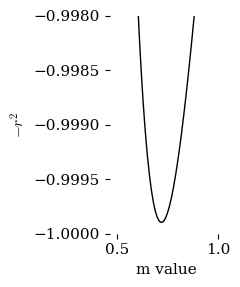

The optimal value for r is 0.720 for rsq = -0.99990


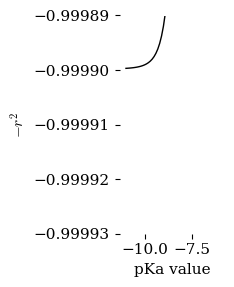

The optimal value for r is -30.786 for rsq = -0.99990
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.9999002391281221
        x: [ 7.221e-01 -1.174e+01]
      nit: 22
      jac: [ 2.950e-06  5.960e-08]
 hess_inv: [[ 5.556e+00 -4.228e+02]
            [-4.228e+02  1.886e+06]]
     nfev: 75
     njev: 25
The optimal value for m is -11.742 and for pka is 0.722 for rsq = 0.99980


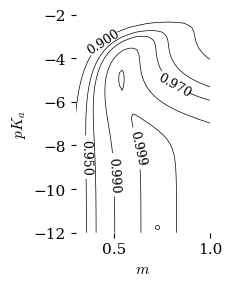

In [ ]:
###################################################
### CURVE FIT FOR PARAMETERS
###################################################

# Try to curve fit for m, pKa and maybe n


def RSQ_function(m):    # returns the RSQ for linefits using the given m factor
    pKa = -9.5
    Ka=10**-pKa
    h_0 = 10**-df1["H0"]
    x = np.log10(df1["Molar_aH2O"]) 
#    y = df1["log_k_obs"]+ m * df1["H0"]
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)

def RSQ_function2(pKa):    # returns the RSQ for linefits using the given pKa Value
    m = 0.72
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"m value",
#       xlim=[0.3,1.0],                  
       ylim=[-1,-0.998]
)

rsq_range=[]
r_range = np.arange(0.5,1,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")



##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"pKa value",
#       xlim=[0.3,1.0],                  
       ylim=[-0.99993,-0.99989]
         )


rsq_range=[]
r_range = np.arange(-11,-6.0,0.1)
for r in r_range:
    rsq = RSQ_function2(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function2)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")








### CONTOUR PLOT


################################################################################
### Define a function to be minimized
################################################################################


def RSQ_function3(params):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m, pKa = params
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


################################################################################
### optimize the param list to obtain the minimum result of the function.
################################################################################

r_opt = minimize(RSQ_function3, [0.7,-8])
#print(r_opt)
r_minus, r_plus = r_opt['x']
print(r_opt)
print(f"The optimal value for m is {r_plus:0.3f} and for pka is {r_minus:0.3f} for rsq = {r_opt['fun']**2:0.5f}")

################################################################################
### Create a plot object
################################################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$pK_a$", 
          xlabel=r"$m$",                
          xlim=[0.3,1.0],                  
          ylim=[-12,-2]
         )

################################################################################
### use the function to caluate the RSQ for the line fit at every value of r+ and r-
## and then plot the result as a contour plot
################################################################################

mlist = np.linspace(0.3, 1.0, 50)
pKalist = np.linspace(-12.0, -2.0, 50)         #  vary r_plus and r_minus from -1.1 to +1.1

### This loop cycles through all the pairings of r+ and r- and calculates RSQ for each case
l1 = []                                
for pKa in pKalist:
    l2 = []
    for m in mlist:
        rsq = RSQ_function3([m,pKa])    
        l2.append(rsq)
    l1.append(l2)
l3 = np.matrix(l1)
#print(l3)

### Set up contour plot
X, Y = np.meshgrid(mlist, pKalist)
#levels = [0.95,0.96,0.97, 0.98, 0.99, 0.995, 0.999, 0.9998]
#levels = [0.90,0.95,0.97, 0.98, 0.995, 0.999, 0.9998]
levels = [0.90,0.95,0.97, 0.99, 0.999]

### plot lines along the x and y axes
ax.hlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)
ax.vlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)

### Plot the contour lines as thick white lines 
#ax.contour(X, Y, -l3, levels, colors = "white", linewidths=3, zorder = 2)

### Create contour plot as 'CS' and then plot 'CS' with lables
CS = ax.contour(X, Y, -l3, levels, colors = "black", linewidths=0.5, zorder = 2)
ax.clabel(CS, inline=True, fontsize=9)

### Plot the true minimum value as a point
ax.plot(r_minus,r_plus,"o", color="white", markeredgecolor = "black", markeredgewidth = 0.5, markersize = 3)
#ax.plot(pKa,m,"o", color="black", markersize = 2)

#ax.hlines(-9.5,0.3,1, color ="red", linewidths =0.5, zorder=0)
#ax.vlines(0.73,-12,-2, color ="red", linewidths =0.5, zorder=0)


################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("fig15.pdf")   # use this to save the figure in PDF format

plt.show()

#print(mlist)
#print(pKalist)





<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:48: SyntaxWarning: invalid escape sequence '\l'
<>:99: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:48: SyntaxWarning: invalid escape sequence '\l'
<>:99: SyntaxWarning: invalid escape sequence '\l'
/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_36739/3577462928.py:45: SyntaxWarning: invalid escape sequence '\l'
  x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"
/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_36739/3577462928.py:48: SyntaxWarning: invalid escape sequence '\l'
  y_label = "$\log{(k_{obs} / {s}^{-1})} + \log\\frac{h_0^m}{K_a^m+h_0^m}$"
/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_36739/3577462928.py:99: SyntaxWarning: invalid escape sequence '\l'
  x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"


LinregressResult(slope=2.0126754231252466, intercept=2.931482188788384, rvalue=0.9999487626387326, pvalue=2.689903001823023e-23, stderr=0.006143310495002412, intercept_stderr=0.007326693070337065)


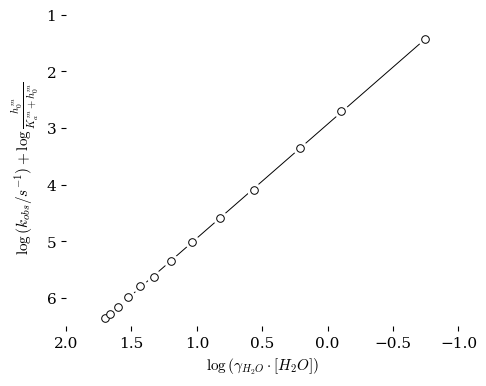

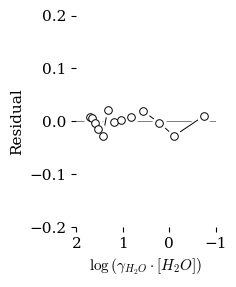

In [ ]:
###################################################
### MAKE PLOT
###################################################

pKa = -9.5
#pKa = -4.95

Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.72
#m = 0.54

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])

#y = df1["log_k_obs"]
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = "$\%wt {H_2SO_4}$"
#x_label = "$\log{a_{H_2O}}$"
x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

#y_label = "$\log{(k_{obs} / {s}^{-1})} + mH_0$"
y_label = "$\log{(k_{obs} / {s}^{-1})} + \log\\frac{h_0^m}{K_a^m+h_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[2,-1],
           ylim=[6.5,0.9]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig16.pdf")
plt.show()


###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

#x_label = "$\log{a_{H_2O}}$"
x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[2,-1],
           ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "white", linewidth=3, 
        zorder = 1)
ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 2)
ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig16r.pdf")
plt.show()


LinregressResult(slope=2.0126754231252466, intercept=2.931482188788384, rvalue=0.9999487626387326, pvalue=2.689903001823023e-23, stderr=0.006143310495002412, intercept_stderr=0.007326693070337065)


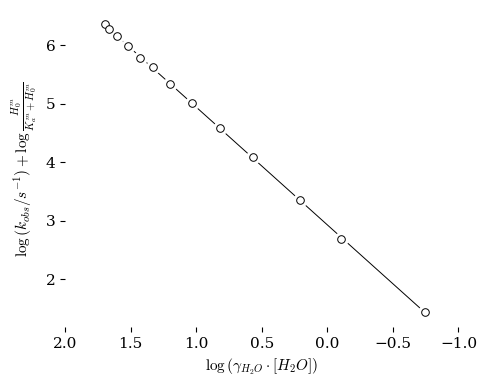

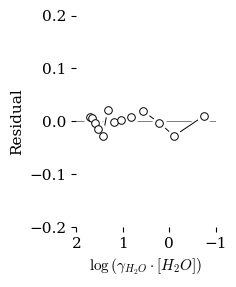

In [ ]:
###################################################
### MAKE PLOT
###################################################

pKa = -9.5
#pKa = -4.95

Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.72
#m = 0.54

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])

#y = df1["log_k_obs"]
y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = r"$\%wt {H_2SO_4}$"
#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

#y_label = r"$\log{(k_{obs} / {s}^{-1})} + mH_0$"
y_label = r"$\log{(k_{obs} / {s}^{-1})} + \log\frac{H_0^m}{K_a^m+H_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set(xlim=[2,-1],
           #ylim=[2.5,-0.5]
           #ylim=[2.5,-0.5]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 0)

plt.savefig("fig18.pdf")
plt.show()


###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  

###################################################
### Set up labels
###################################################

#x_label = r"$\log{a_{H_2O}}$"
x_label = r"$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set(xlim=[2,-1],
        ylim=[-.2,.2]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "white", linewidth=3, 
        zorder = 1)
ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 2)
ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

plt.savefig("fig18r.pdf")
plt.show()
